In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import warnings
import plotly.io as pio
import plotly.express as px
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
df_store = pd.read_excel("Superstore.xls")
df_store.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
df_store.info()

### Univariate Anomaly Detection on Store Sales 

Explore and analyse the Sales to detect any anomaly

In [7]:
df_store['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

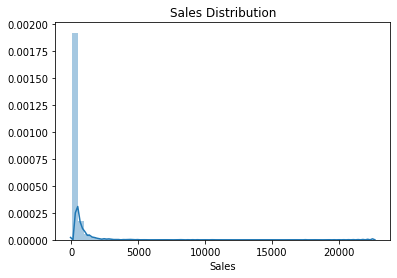

In [9]:
sns.distplot(df_store['Sales'])
plt.title("Sales Distribution");

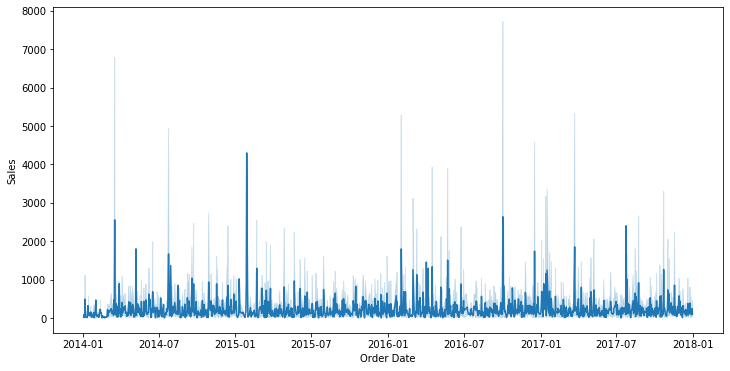

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(x=df_store['Order Date'], y=df_store['Sales']);

### Upper Limit detection using three sigma rule

Applying the three sigma rule to get the upper limit for outliers. 
<br/>Here,
<br/> &nbsp; &nbsp; &nbsp; Threshold = mean + 3*standard deviation 
<br/> Any point beyond this threshold is outlier.

In [13]:
mean = df_store.Sales.mean()
std = df_store.Sales.std()

# three sigma threshold value
threshold_value = mean + 3*std 

print(threshold_value)

2099.5933023565394


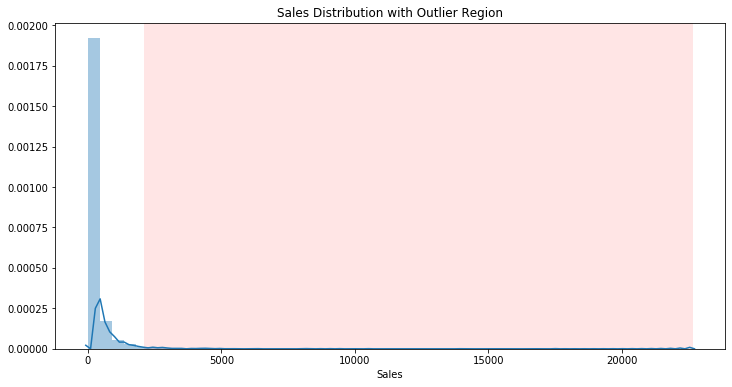

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.distplot(df_store['Sales'])
plt.axvspan(threshold_value, df_store['Sales'].max(), facecolor='r', alpha=0.1)
plt.title("Sales Distribution with Outlier Region");

Top 5 outliers

In [21]:
sales_outliers_df = df_store['Sales'][df_store['Sales'] > threshold_value]
print('Total Sales Outliers:', len(sales_outliers_df))
sales_outliers_sorted = sales_outliers_df.sort_values(ascending=False)
sales_outliers_sorted.head(5)

Total Sales Outliers: 127


2697    22638.480
6826    17499.950
8153    13999.960
2623    11199.968
4190    10499.970
Name: Sales, dtype: float64

### Isolation Forest

Using isolation forest for Outlier detection

In [25]:
from sklearn.ensemble import IsolationForest

sales_ifmodel = IsolationForest(n_estimators=100,
                                contamination=0.01)
sales_ifmodel.fit(df_store[['Sales']])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

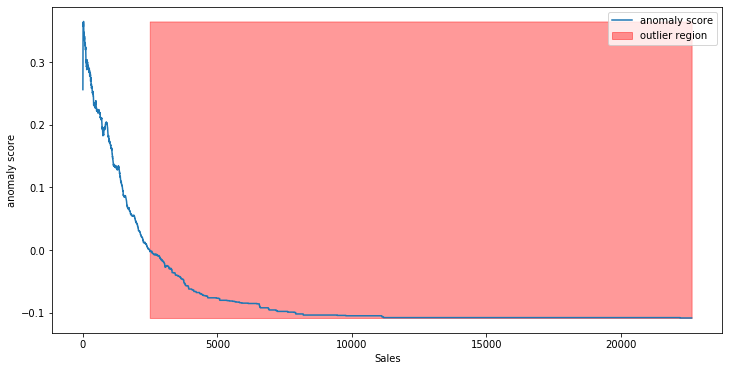

In [26]:
xx = np.linspace(df_store['Sales'].min(), df_store['Sales'].max(), len(df_store)).reshape(-1,1)
anomaly_score = sales_ifmodel.decision_function(xx)
outlier = sales_ifmodel.predict(xx)
plt.figure(figsize=(12, 6))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales');

In [28]:
outlier_predictions = sales_ifmodel.predict(df_store[['Sales']])

sales_outliers_df = df_store[['Sales']]
sales_outliers_df['Outlier'] = outlier_predictions
sales_outliers_df = sales_outliers_df[sales_outliers_df['Outlier'] == -1]['Sales']

print('Total Sales Outliers:', len(sales_outliers_df))
sales_outliers_sorted = sales_outliers_df.sort_values(ascending=False)
sales_outliers_sorted.head(5)

Total Sales Outliers: 100


2697    22638.480
6826    17499.950
8153    13999.960
2623    11199.968
4190    10499.970
Name: Sales, dtype: float64

Top 10 outliers

In [30]:
df_store.loc[sales_outliers_sorted.index.tolist()].head(10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2697,2698,CA-2014-145317,2014-03-18,2014-03-23,Standard Class,SM-20320,Sean Miller,Home Office,United States,Jacksonville,...,32216,South,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.480,6,0.5,-1811.0784
6826,6827,CA-2016-118689,2016-10-02,2016-10-09,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,47905,Central,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.950,5,0.0,8399.9760
8153,8154,CA-2017-140151,2017-03-23,2017-03-25,First Class,RB-19360,Raymond Buch,Consumer,United States,Seattle,...,98115,West,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,13999.960,4,0.0,6719.9808
2623,2624,CA-2017-127180,2017-10-22,2017-10-24,First Class,TA-21385,Tom Ashbrook,Home Office,United States,New York City,...,10024,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,11199.968,4,0.2,3919.9888
4190,4191,CA-2017-166709,2017-11-17,2017-11-22,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Newark,...,19711,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,10499.970,3,0.0,5039.9856
9039,9040,CA-2016-117121,2016-12-17,2016-12-21,Standard Class,AB-10105,Adrian Barton,Consumer,United States,Detroit,...,48205,Central,OFF-BI-10000545,Office Supplies,Binders,GBC Ibimaster 500 Manual ProClick Binding System,9892.740,13,0.0,4946.3700
4098,4099,CA-2014-116904,2014-09-23,2014-09-28,Standard Class,SC-20095,Sanjit Chand,Consumer,United States,Minneapolis,...,55407,Central,OFF-BI-10001120,Office Supplies,Binders,Ibico EPK-21 Electric Binding System,9449.950,5,0.0,4630.4755
4277,4278,US-2016-107440,2016-04-16,2016-04-20,Standard Class,BS-11365,Bill Shonely,Corporate,United States,Lakewood,...,8701,East,TEC-MA-10001047,Technology,Machines,"3D Systems Cube Printer, 2nd Generation, Magenta",9099.930,7,0.0,2365.9818
8488,8489,CA-2016-158841,2016-02-02,2016-02-04,Second Class,SE-20110,Sanjit Engle,Consumer,United States,Arlington,...,22204,South,TEC-MA-10001127,Technology,Machines,HP Designjet T520 Inkjet Large Format Printer ...,8749.950,5,0.0,2799.9840
6425,6426,CA-2016-143714,2016-05-23,2016-05-27,Standard Class,CC-12370,Christopher Conant,Consumer,United States,Philadelphia,...,19120,East,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,8399.976,4,0.4,1119.9968


Bottom 10 outliers

In [31]:
df_store.loc[sales_outliers_sorted.index.tolist()].tail(10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1805,1806,US-2016-116729,2016-12-25,2016-12-28,First Class,GK-14620,Grace Kelly,Corporate,United States,Los Angeles,...,90049,West,TEC-PH-10002200,Technology,Phones,Samsung Galaxy Note 2,2575.944,7,0.2,257.5944
7474,7475,CA-2014-167199,2014-01-06,2014-01-10,Standard Class,ME-17320,Maria Etezadi,Home Office,United States,Henderson,...,42420,South,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,2573.820,9,0.0,746.4078
6884,6885,CA-2015-120677,2015-05-31,2015-06-04,Standard Class,BD-11320,Bill Donatelli,Consumer,United States,Minneapolis,...,55407,Central,FUR-CH-10002320,Furniture,Chairs,Hon Pagoda Stacking Chairs,2567.840,8,0.0,770.3520
8271,8272,CA-2016-169670,2016-12-25,2016-12-31,Standard Class,JE-15715,Joe Elijah,Consumer,United States,New York City,...,10009,East,FUR-CH-10002331,Furniture,Chairs,Hon 4700 Series Mobuis Mid-Back Task Chairs wi...,2563.056,8,0.1,313.2624
3011,3012,CA-2017-134845,2017-04-17,2017-04-23,Standard Class,SR-20425,Sharelle Roach,Home Office,United States,Louisville,...,80027,West,TEC-MA-10000822,Technology,Machines,Lexmark MX611dhe Monochrome Laser Printer,2549.985,5,0.7,-3399.9800
6010,6011,CA-2015-135580,2015-12-30,2016-01-03,Standard Class,CL-12565,Clay Ludtke,Consumer,United States,Los Angeles,...,90049,West,TEC-MA-10004002,Technology,Machines,Zebra GX420t Direct Thermal/Thermal Transfer P...,2548.560,6,0.2,286.7130
7280,7281,CA-2015-162782,2015-02-21,2015-02-27,Standard Class,PW-19240,Pierre Wener,Consumer,United States,Columbia,...,21044,East,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,2541.980,2,0.0,1270.9900
263,264,US-2014-106992,2014-09-19,2014-09-21,Second Class,SB-20290,Sean Braxton,Corporate,United States,Houston,...,77036,Central,TEC-MA-10003353,Technology,Machines,Xerox WorkCentre 6505DN Laser Multifunction Pr...,2519.958,7,0.4,-251.9958
7937,7938,CA-2017-166093,2017-08-17,2017-08-24,Standard Class,RW-19540,Rick Wilson,Corporate,United States,Brentwood,...,94513,West,OFF-AP-10001058,Office Supplies,Appliances,Sanyo 2.5 Cubic Foot Mid-Size Office Refrigera...,2518.290,9,0.0,654.7554
3443,3444,CA-2017-168858,2017-11-19,2017-11-23,Standard Class,JD-16150,Justin Deggeller,Corporate,United States,New York City,...,10011,East,OFF-AP-10003849,Office Supplies,Appliances,Hoover Shoulder Vac Commercial Portable Vacuum,2504.740,7,0.0,626.1850


## Multivariate Anomaly Detection

Multivariate Anomaly Detction on Sales and profit

In [35]:
cols = ['Discount', 'Profit']
subset_df = df_store[cols]
subset_df.head()

,Discount,Profit
0,0.00,41.9136
1,0.00,219.5820
2,0.00,6.8714
3,0.45,-383.0310
4,0.20,2.5164


Feature Scaling 

In [36]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(0, 1))
subset_df[cols] = mms.fit_transform(subset_df)
subset_df.head()

,Discount,Profit
0,0.0000,0.442794
1,0.0000,0.454639
2,0.0000,0.440458
3,0.5625,0.414464
4,0.2500,0.440168


 ### Clustering Based Local Outlier Factor (CBLOF)

In [42]:
from pyod.models import cblof

cblof_model = cblof.CBLOF(contamination=0.01, random_state=42)
cblof_model.fit(subset_df)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.01, n_clusters=8, n_jobs=1, random_state=42,
   use_weights=False)

Top 5 Outliears

In [43]:
outlier_predictions = cblof_model.predict(subset_df)

outliers_df = subset_df.copy(deep=True)
outliers_df['Outlier'] = outlier_predictions
outliers_df = outliers_df[outliers_df['Outlier'] == 1]

print('Total Outliers:', len(outliers_df))
outliers_sorted = outliers_df.sort_values(by=['Profit', 'Discount'], ascending=False)
outliers_sorted.head(5)

Total Outliers: 100


,Discount,Profit,Outlier
6826,0.0,1.000000,1
8153,0.0,0.888000,1
4190,0.0,0.776000,1
9039,0.0,0.769759,1
4098,0.0,0.748699,1


Bottom 5 Outliears

In [50]:
outliers_sorted.tail(5)

,Discount,Profit,Outlier
27,0.625,0.328996,1
2697,0.625,0.319261,1
9639,0.500,0.315845,1
683,0.625,0.184000,1
7772,0.875,0.000000,1


### Isolation Forest

In [47]:
from pyod.models import iforest

if_model = iforest.IForest(contamination=0.01, random_state=42)
if_model.fit(subset_df)

IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=42, verbose=0)

In [48]:

if_outliears = if_model.predict(subset_df)
out_df = subset_df.copy(deep=True)
out_df['Outlier'] = if_outliears
out_df = outliers_df[outliers_df['Outlier'] == 1]

print('Total Outliers:', len(out_df))
outliers_sorted = out_df.sort_values(by=['Profit', 'Discount'], ascending=False)
outliers_sorted.head(5)

Total Outliers: 100


,Discount,Profit,Outlier
6826,0.0,1.000000,1
8153,0.0,0.888000,1
4190,0.0,0.776000,1
9039,0.0,0.769759,1
4098,0.0,0.748699,1


In [51]:
outliers_sorted.tail(5)

,Discount,Profit,Outlier
27,0.625,0.328996,1
2697,0.625,0.319261,1
9639,0.500,0.315845,1
683,0.625,0.184000,1
7772,0.875,0.000000,1
